In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, mannwhitneyu, skew, kurtosis, f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from joblib import Parallel, delayed

In [54]:
from utils import load_config, perform_statistical_tests
from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data
from features import (
    LowLevelFeatureExtractor, 
    HighLevelFeatureExtractor, 
    plot_low_level_feature_dist, 
    plot_high_level_feature_dist, 
    perform_pca_and_plot
)

In [4]:
config    = load_config()
cache_dir = config['data_paths']['codecfake']['cache_files']
audio_ids = get_codecfake_audio_id_list()

In [5]:
iterable_ds = load_audio_data(
    audio_ids=audio_ids[:500],
    dataset='codecfake',
    cache_dir=cache_dir
)

In [6]:
rows = []
for audio in iterable_ds:
    audio_id  = audio['audio_id']
    audio_arr = audio['audio']['array']
    srate     = audio['audio']['sampling_rate']
    real_fake = audio['real_or_fake']

    rows.append({
        'audio_id': audio_id,
        'audio_arr': audio_arr,
        'srate': srate,
        'real_or_fake': real_fake
    })

In [7]:
df = pd.DataFrame(rows)
df.head()

,audio_id,audio_arr,srate,real_or_fake
0,p225_002,"[-0.0045166015625, -0.00665283203125, -0.00607...",48000,R
1,p225_002,"[0.001953125, 0.001556396484375, 0.00164794921...",16000,F03
2,p225_002,"[-0.001220703125, -0.001129150390625, -0.00103...",24000,F04
3,p225_002,"[0.001861572265625, 0.001922607421875, 0.00195...",16000,F01
4,p225_002,"[-0.00335693359375, -0.0032958984375, -0.00320...",48000,F05


### Detailed Low Level Features

In [55]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['spectral'])

In [56]:
low_level_features   = pd.DataFrame(list(audio_processor.low_level_feature_generator(df.iloc[:5])))
low_level_feature_df = pd.DataFrame(low_level_features)
low_level_feature_df.head()

Processing Audios: 100%|██████████| 5/5 [00:00<00:00, 21.07it/s]


,audio_id,real_or_fake,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,spectral_rolloff,zero_crossing_rate,mfccs,chroma_stft,spectral_flux
0,p225_002,R,"[829.4145187838415, 661.496958455381, 442.6783...","[1510.326546535265, 1383.9102101047506, 1174.7...","[11.291859341535664, 16.916747499376296, 22.22...","[0.002798787648578932, 0.0008228998272063862, ...","[1867.1875, 1226.5625, 687.5, 687.5, 898.4375,...","[0.00537109375, 0.005859375, 0.00634765625, 0....","[-493.46367947184245, -505.3487799052732, -515...","[0.9684745830596301, 0.913118083385125, 0.9379...","[1.2081258501078092, 1.9080356555927838, 1.284..."
1,p225_002,F03,"[1069.4187478998572, 637.0547651030942, 370.36...","[1940.535132849958, 1529.5960988060424, 1148.6...","[18.39940091484689, 21.239724615563638, 20.840...","[0.0026924060781607037, 0.0005084176100987905,...","[2835.9375, 968.75, 250.0, 414.0625, 734.375, ...","[0.00146484375, 0.001953125, 0.001953125, 0.00...","[-540.5051397245809, -538.5494203495595, -536....","[0.9677985648656308, 0.787370244795954, 0.9266...","[1.181092488661578, 1.8572492002574343, 1.1565..."
2,p225_002,F04,"[729.9637507875887, 522.6023419619487, 421.068...","[1562.8883935041792, 1316.9819802115717, 1250....","[12.776180144990716, 16.68635227210276, 27.924...","[0.0011371893766648053, 0.00035142732287487204...","[1429.6875, 617.1875, 273.4375, 195.3125, 218....","[0.00634765625, 0.00732421875, 0.00732421875, ...","[-518.7511977161419, -519.60214768256, -525.26...","[0.886233560485923, 0.965461538250158, 0.90895...","[1.3510447249423867, 1.7158769349802925, 1.234..."
3,p225_002,F01,"[521.3902225491731, 438.1140428433425, 351.525...","[1368.733604690056, 1253.619013189369, 1133.14...","[19.988859797431736, 24.837846454345446, 21.83...","[0.00038271294858709814, 0.0001961472135381932...","[679.6875, 335.9375, 132.8125, 4218.75, 4500.0...","[0.001953125, 0.00244140625, 0.02783203125, 0....","[-527.5679663278828, -527.3073295996451, -526....","[0.7183639023327838, 0.5640943858745837, 0.800...","[1.552897022509635, 2.2842818705316987, 1.1813..."
4,p225_002,F05,"[720.8583200851683, 664.5686611174235, 583.125...","[1426.667105670598, 1362.2742731282342, 1324.2...","[18.752303484237306, 19.081640178500304, 23.58...","[0.0014925099428683398, 0.0009488775957742423,...","[1554.6875, 1257.8125, 1023.4375, 914.0625, 96...","[0.00537109375, 0.005859375, 0.0078125, 0.0073...","[-527.3005230751635, -526.1854591447704, -534....","[0.6626814448860227, 0.737018679479439, 0.9999...","[0.824437317603198, 1.2115661863419493, 0.9521..."


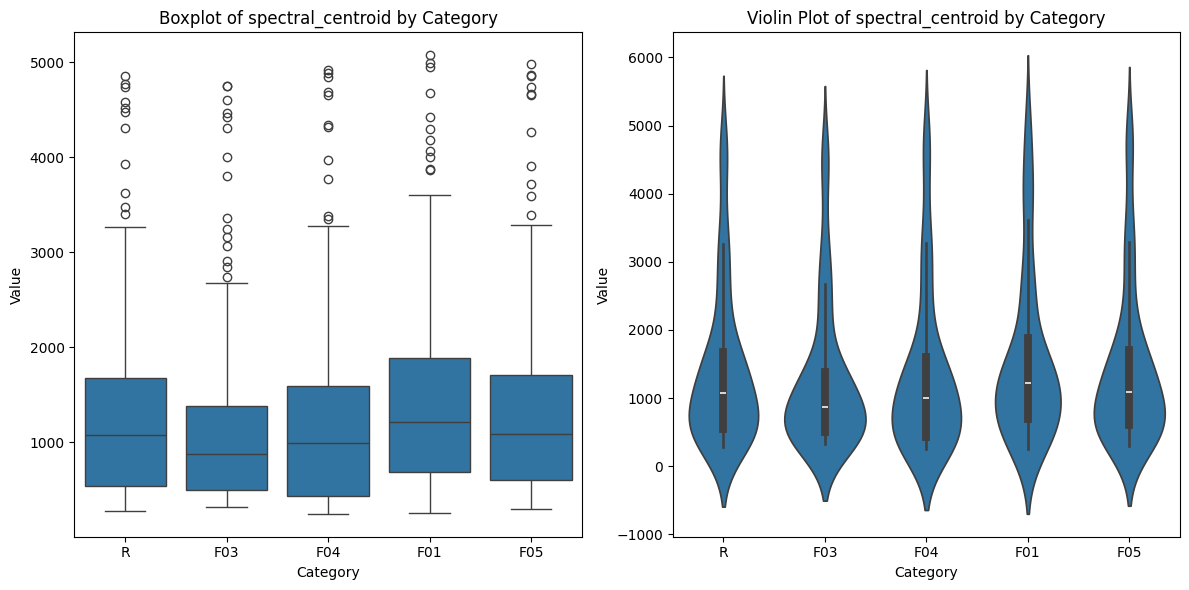

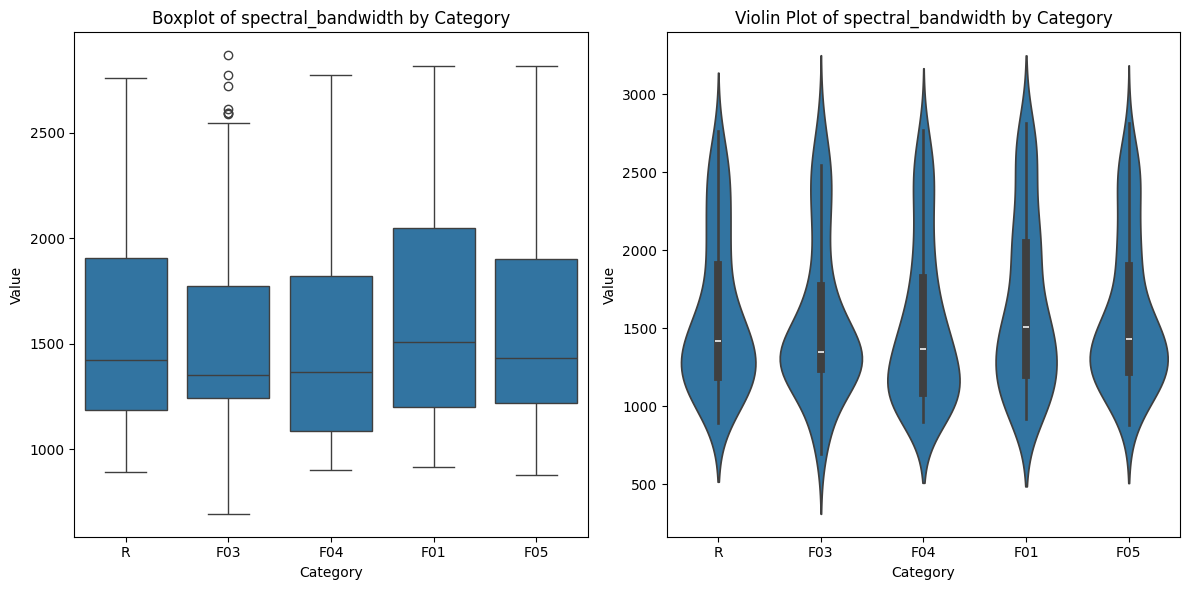

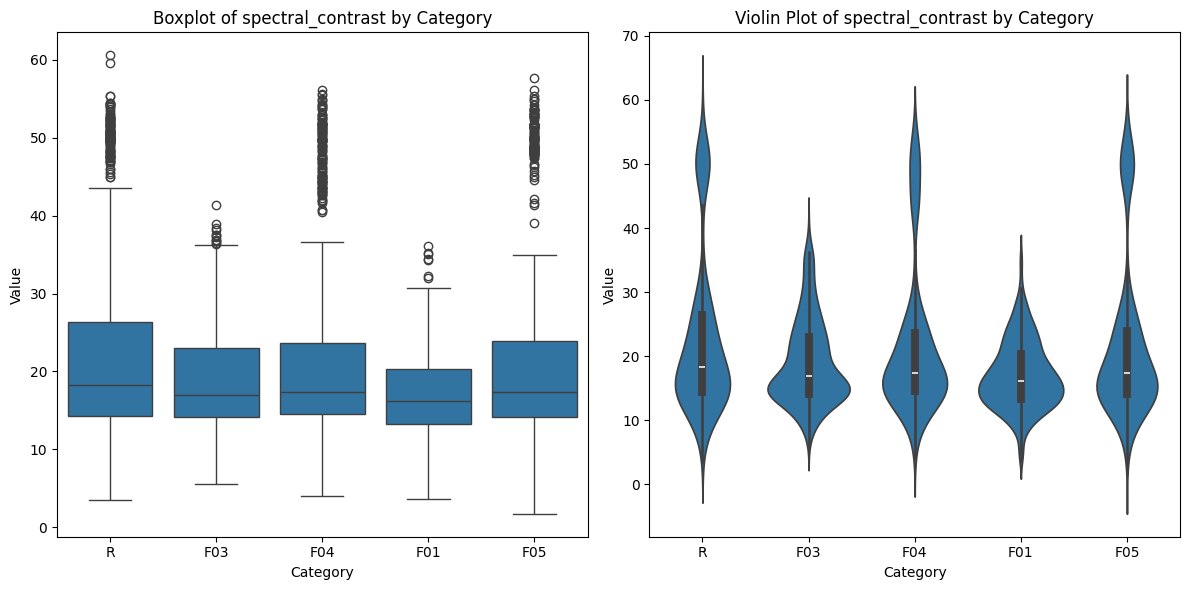

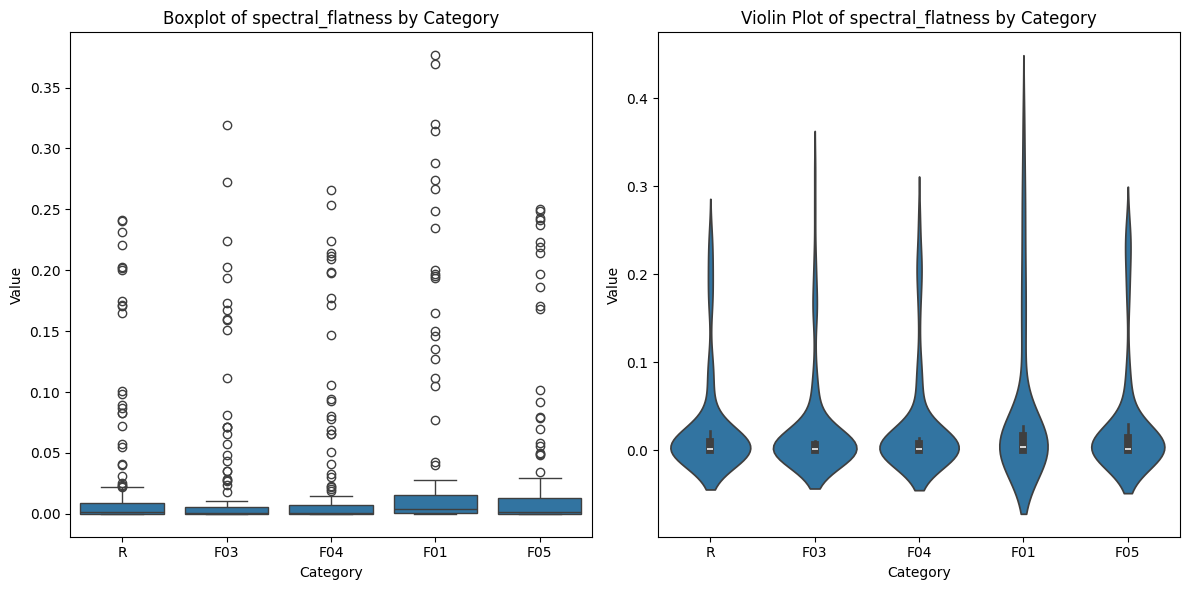

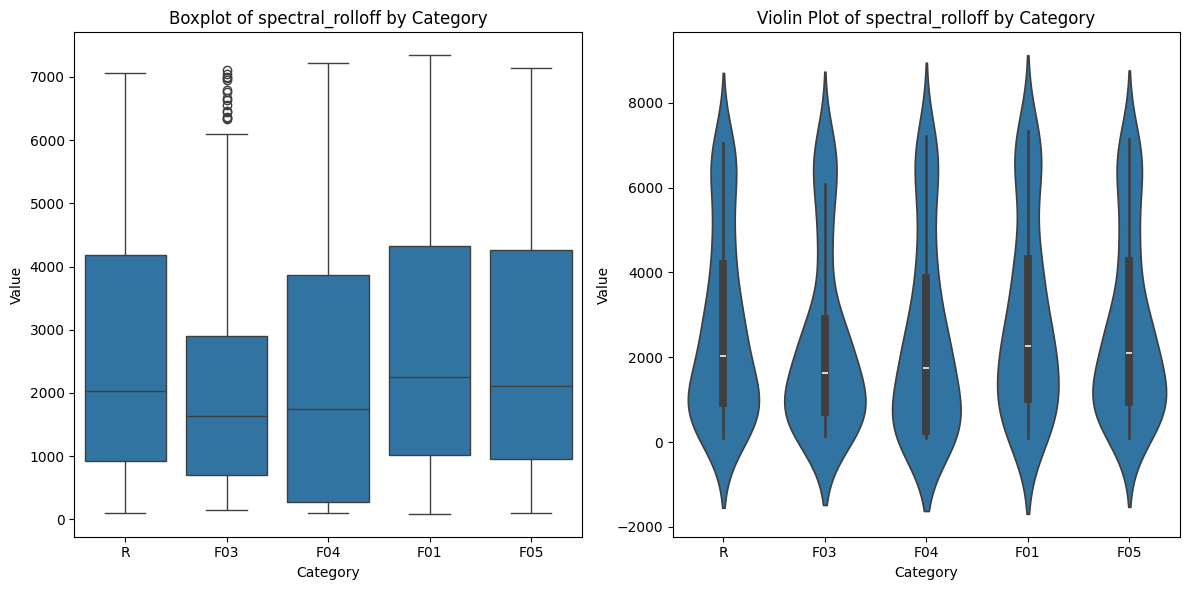

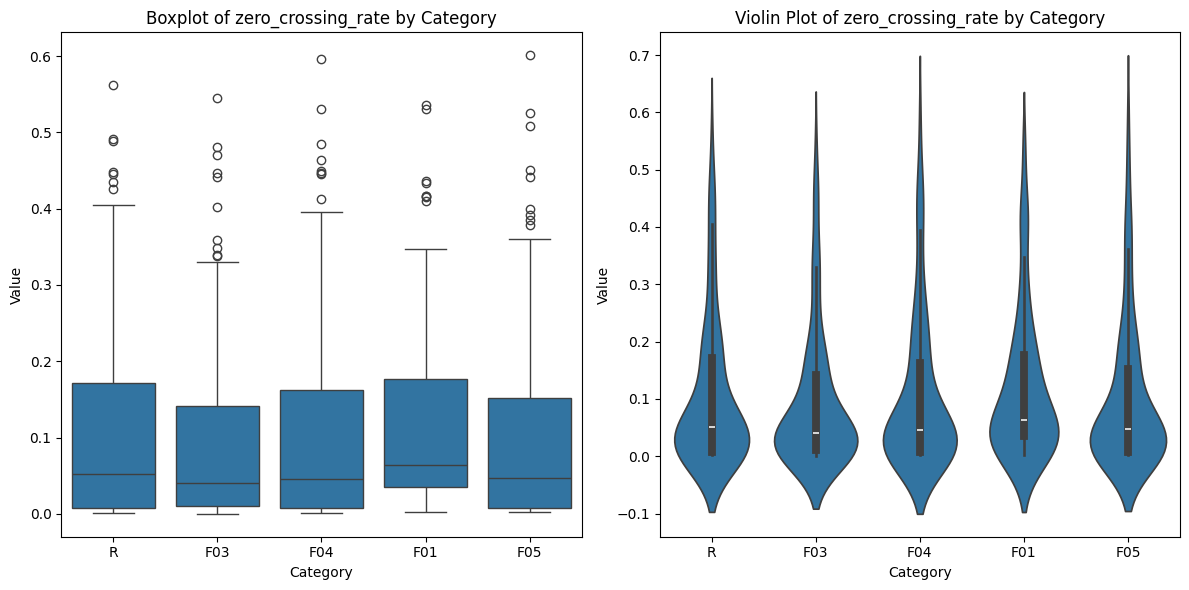

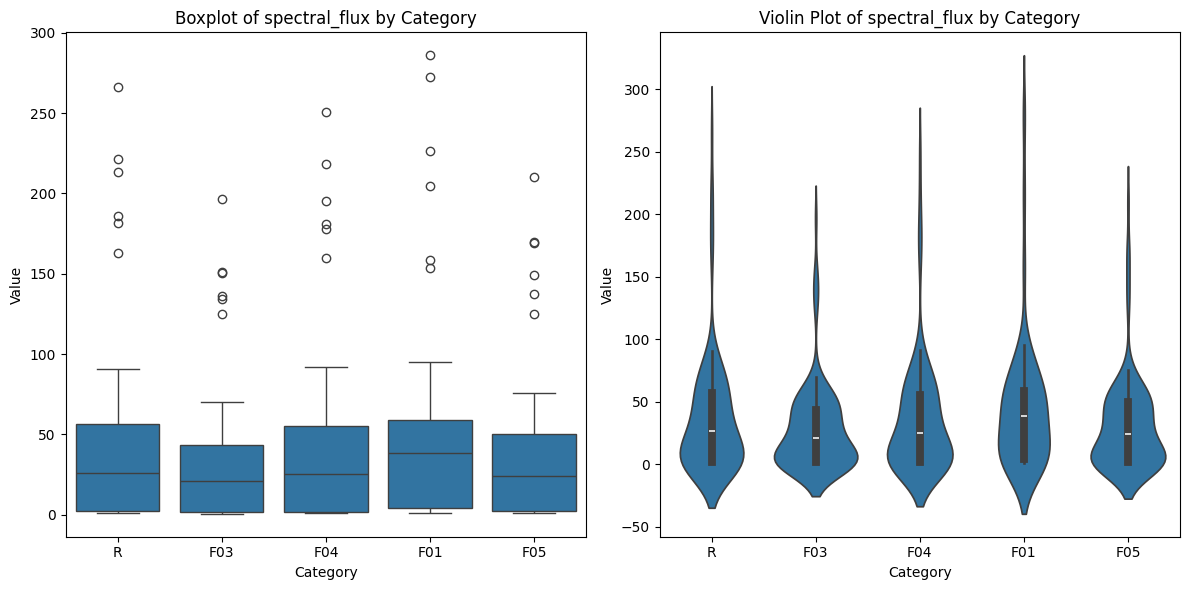

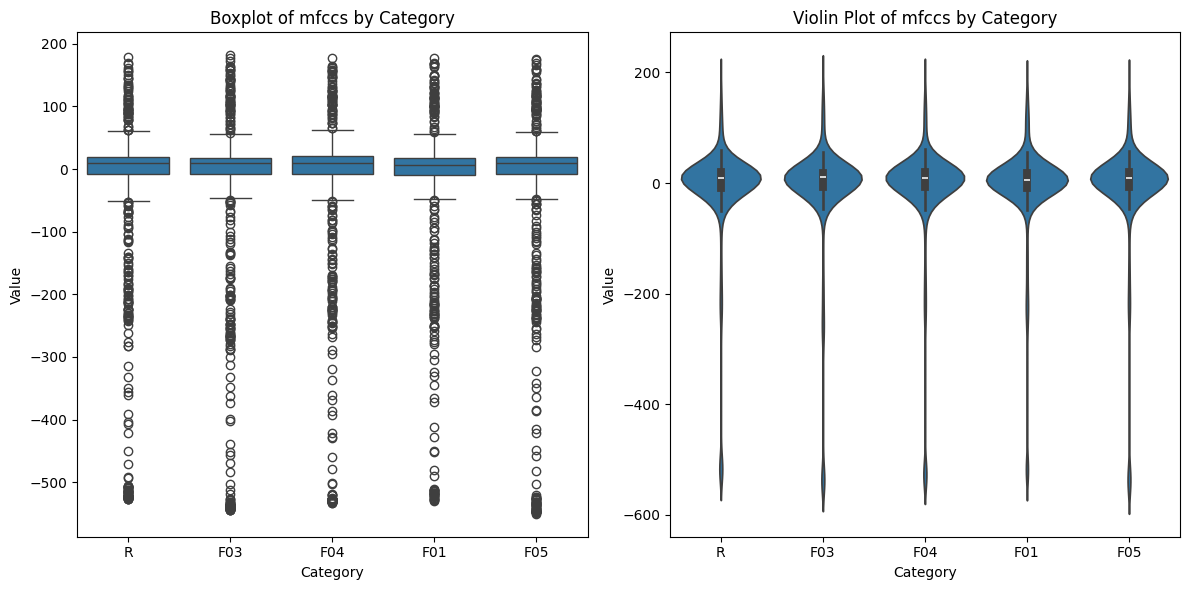

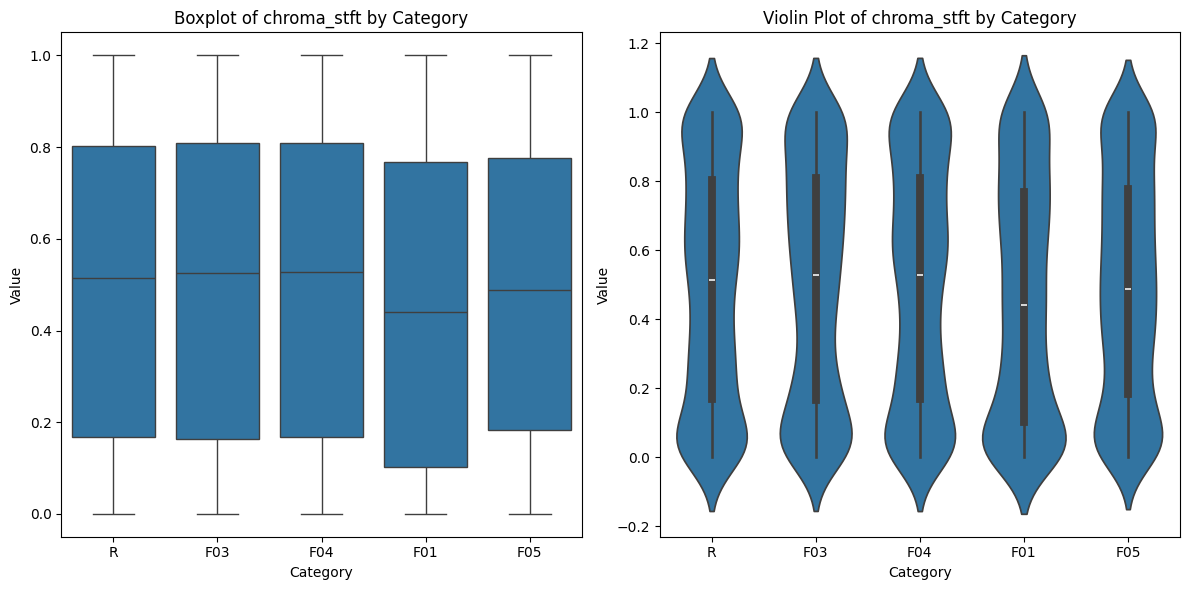

In [10]:
low_level_feature_df = pd.DataFrame(low_level_features)
for feature in ['spectral_centroid', 'spectral_bandwidth', 'spectral_contrast', 'spectral_flatness', 'spectral_rolloff', 'zero_crossing_rate', 'spectral_flux', 'mfccs', 'chroma_stft']:
    plot_low_level_feature_dist(low_level_feature_df, feature)

**No Obvious/Significant Difference in the distribution of detailed low level features**

In [57]:
del low_level_features
del low_level_feature_df

### Extract High level features

In [60]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['spectral'])
feature_computer = HighLevelFeatureExtractor()

In [61]:
low_level_gen        = audio_processor.low_level_feature_generator(df.iloc[:2])
high_level_features  = list(feature_computer.high_level_feature_generator(low_level_gen))
high_level_features_df = pd.DataFrame(high_level_features)
high_level_features_df

Processing Audios: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


,audio_id,real_or_fake,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_var,spectral_centroid_min,spectral_centroid_max,spectral_centroid_range,spectral_centroid_25th_percentile,spectral_centroid_50th_percentile,...,chroma_12_std,chroma_12_var,chroma_12_min,chroma_12_max,chroma_12_range,chroma_12_25th_percentile,chroma_12_50th_percentile,chroma_12_75th_percentile,chroma_12_skew,chroma_12_kurtosis
0,p225_002,R,1407.277479,1139.511158,1.298486e+06,273.979621,4860.736866,4586.757245,538.847218,1075.098178,...,0.327059,0.106968,0.003022,1.0,0.996978,0.139075,0.421000,0.737295,0.250352,-1.328143
1,p225_002,F03,1269.150323,1085.214354,1.177690e+06,319.092868,4752.988182,4433.895314,501.144619,872.714022,...,0.335638,0.112653,0.002458,1.0,0.997542,0.186093,0.596748,0.808374,-0.194552,-1.368044


**Using Parallel Processing**

In [ ]:
def extract_features(row, audio_processor, feature_computer):
    low_level_features = audio_processor.extract_features(row)
    high_level_features = feature_computer.compute_high_level_features(low_level_features)
    return high_level_features


In [38]:
audio_processor  = LowLevelFeatureExtractor(target_sr=16000, include_only=['spectral'])
feature_computer = HighLevelFeatureExtractor()

high_level_features   = Parallel(n_jobs=4)(delayed(extract_features)(row, audio_processor, feature_computer) for _, row in df.iterrows())
high_level_feature_df = pd.DataFrame(high_level_features)
high_level_feature_df

,audio_id,real_or_fake,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_var,spectral_centroid_min,spectral_centroid_max,spectral_centroid_range,spectral_centroid_25th_percentile,spectral_centroid_50th_percentile,...,chroma_12_std,chroma_12_var,chroma_12_min,chroma_12_max,chroma_12_range,chroma_12_25th_percentile,chroma_12_50th_percentile,chroma_12_75th_percentile,chroma_12_skew,chroma_12_kurtosis
0,p225_002,R,1407.277479,1139.511158,1.298486e+06,273.979621,4860.736866,4586.757245,538.847218,1075.098178,...,0.327059,0.106968,0.003022,1.0,0.996978,0.139075,0.421000,0.737295,0.250352,-1.328143
1,p225_002,F03,1269.150323,1085.214354,1.177690e+06,319.092868,4752.988182,4433.895314,501.144619,872.714022,...,0.335638,0.112653,0.002458,1.0,0.997542,0.186093,0.596748,0.808374,-0.194552,-1.368044
2,p225_002,F04,1336.049769,1171.331560,1.372018e+06,247.256673,4922.406802,4675.150129,433.114366,997.420786,...,0.333710,0.111363,0.001287,1.0,0.998713,0.195441,0.490337,0.785119,0.016237,-1.377818
3,p225_002,F01,1540.345739,1212.507952,1.470176e+06,257.468837,5074.111834,4816.642997,688.193002,1217.335638,...,0.340248,0.115768,0.000463,1.0,0.999537,0.179530,0.509616,0.833421,-0.070133,-1.337199
4,p225_002,F05,1414.717840,1149.669533,1.321740e+06,295.103707,4982.683428,4687.579722,604.047516,1091.148701,...,0.331909,0.110164,0.002529,1.0,0.997471,0.139053,0.410088,0.741189,0.240421,-1.348975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,p227_037,R,1552.956324,999.075044,9.981509e+05,388.172970,4600.922167,4212.749197,882.891409,1258.618262,...,0.316751,0.100331,0.025081,1.0,0.974919,0.265589,0.480143,0.823762,0.075950,-1.363264
3496,p227_037,F05,1576.434714,984.655802,9.695470e+05,498.677006,4551.413890,4052.736884,933.510378,1286.137045,...,0.296704,0.088033,0.026249,1.0,0.973751,0.307225,0.492591,0.815712,0.023335,-1.246457
3497,p227_037,F01,1664.541240,1019.091773,1.038548e+06,363.770847,4487.643623,4123.872775,1012.747287,1364.705405,...,0.323513,0.104660,0.010509,1.0,0.989491,0.268066,0.594839,0.823435,-0.153348,-1.287998
3498,p227_037,F06,1420.889072,1039.009012,1.079540e+06,323.817544,4574.689581,4250.872037,711.868542,1094.667566,...,0.277798,0.077172,0.029216,1.0,0.970784,0.329649,0.509030,0.744800,0.185717,-0.954617


In [39]:
stats_df = perform_statistical_tests(high_level_feature_df)
stats_df

,feature,t_stat,t_p_val,u_stat,u_p_val,effect_size,f_stat,f_p_val
0,spectral_centroid_mean,1.369696,0.171224,781180.0,0.136105,0.065041,1.753959,0.185466
1,spectral_centroid_std,-0.722790,0.470057,734608.0,0.461883,-0.034807,0.516058,0.472576
2,spectral_centroid_var,-0.764145,0.445045,734608.0,0.461883,-0.036664,0.568492,0.450909
3,spectral_centroid_min,2.738781,0.006318,835249.0,0.000046,0.126855,6.382160,0.011571
4,spectral_centroid_max,0.114091,0.909199,752626.0,0.900124,0.005457,0.012513,0.910938
...,...,...,...,...,...,...,...,...
335,chroma_12_25th_percentile,0.073307,0.941583,750581.0,0.977862,0.003532,0.005318,0.941869
336,chroma_12_50th_percentile,0.445516,0.656087,753970.0,0.849504,0.021319,0.191220,0.661930
337,chroma_12_75th_percentile,-0.337578,0.735783,735564.0,0.490163,-0.016020,0.106281,0.744439
338,chroma_12_skew,-0.678673,0.497572,738815.0,0.592895,-0.032368,0.437987,0.508139


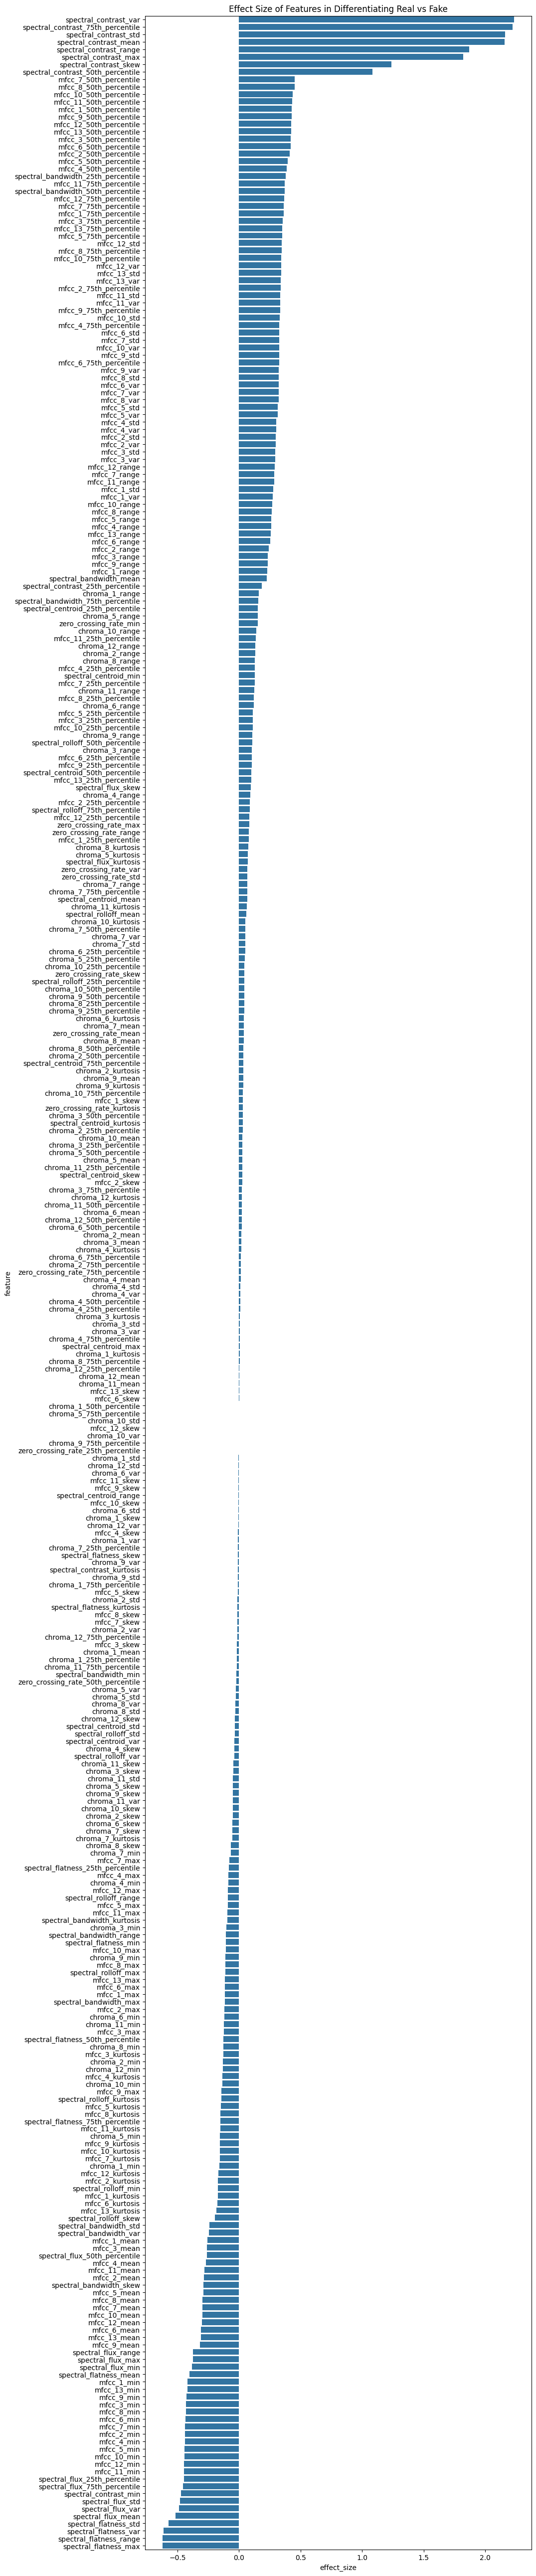

In [40]:
# Visualize the results
plt.figure(figsize=(10, 66))
sns.barplot(x='effect_size', y='feature', data=stats_df.sort_values(by='effect_size', ascending=False))
plt.title('Effect Size of Features in Differentiating Real vs Fake')
plt.show()

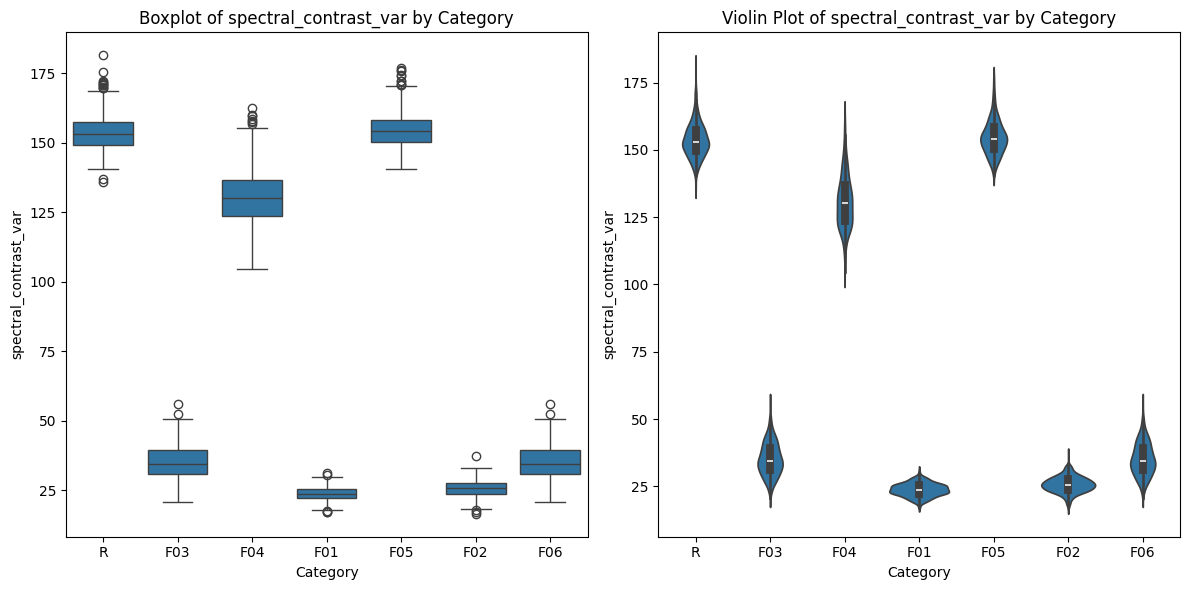

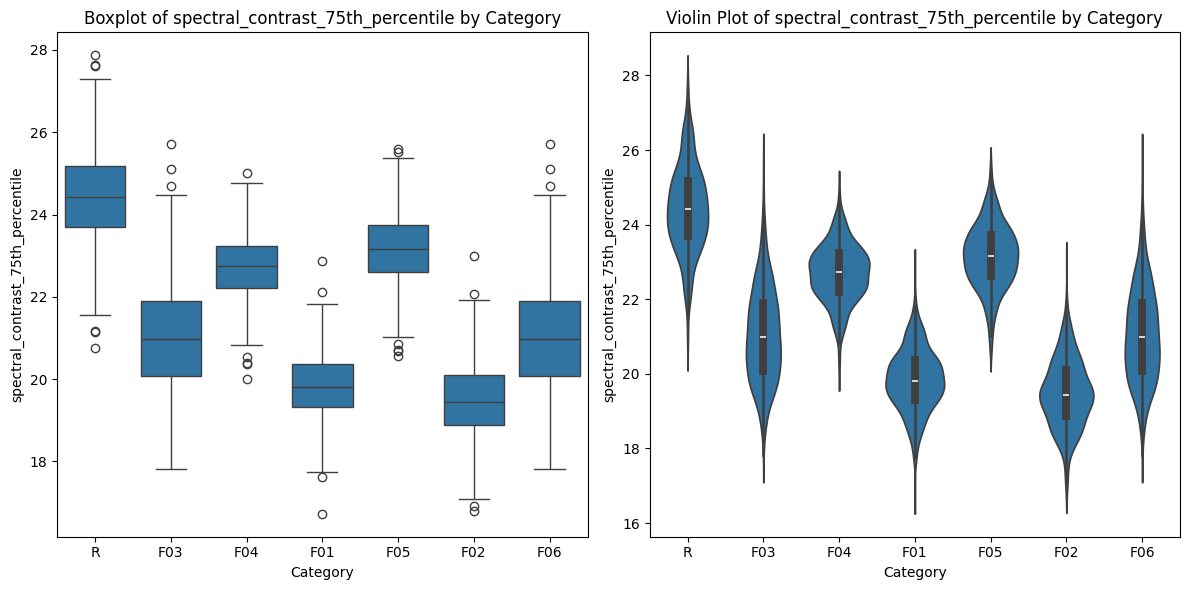

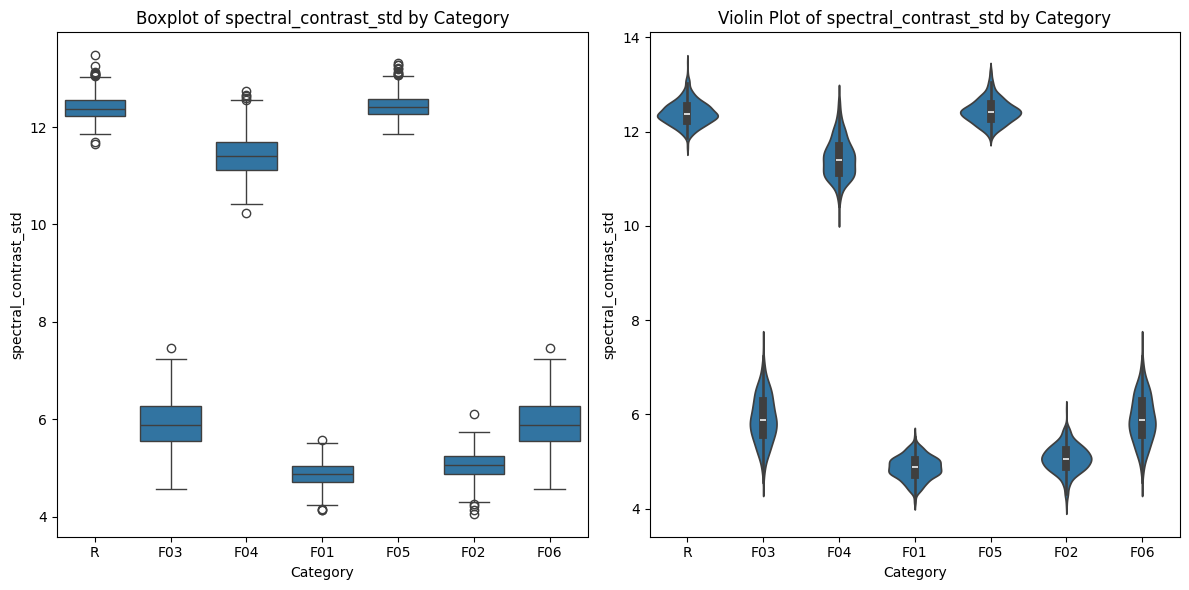

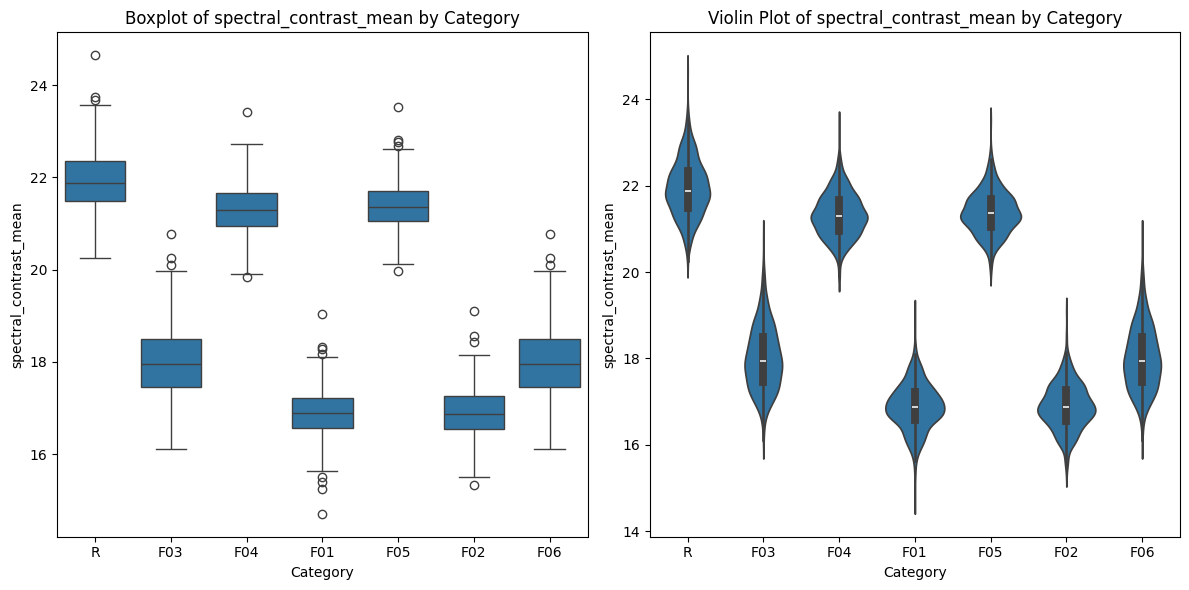

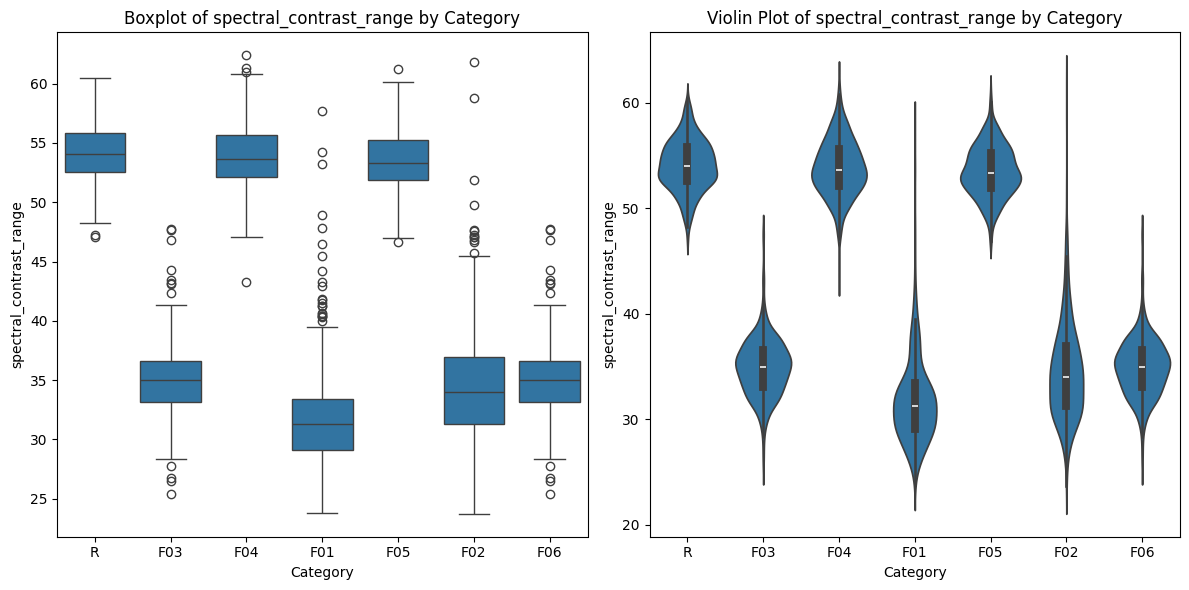

In [41]:
all_features = stats_df.sort_values(by=['effect_size'], ascending=False).feature.tolist()
plot_high_level_feature_dist(high_level_feature_df, all_features[:5])

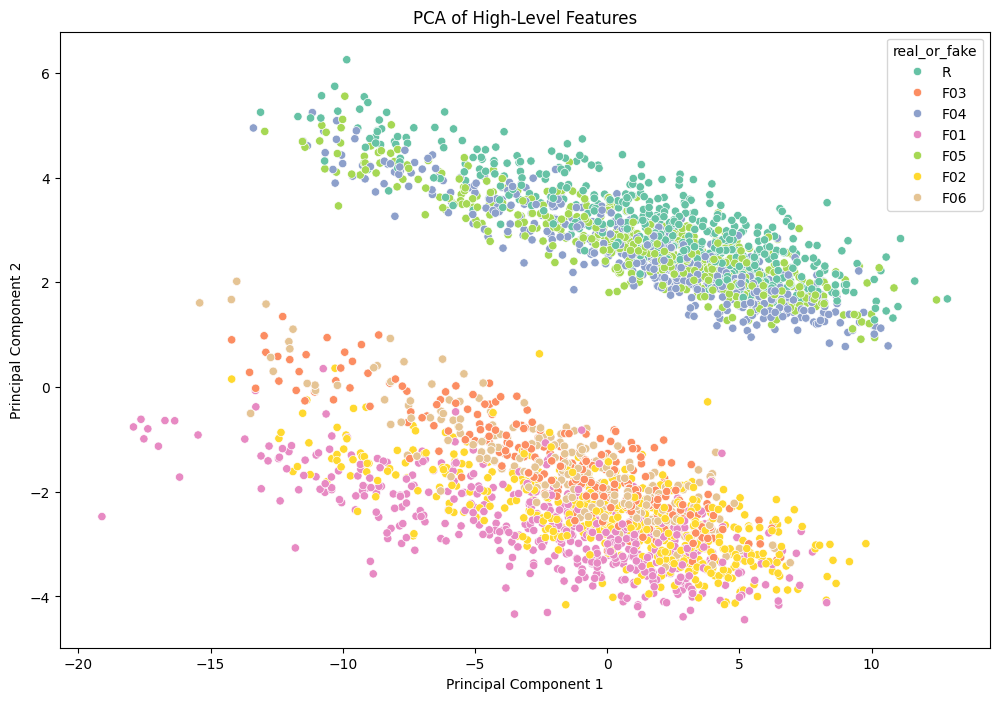

In [42]:
perform_pca_and_plot(high_level_feature_df, all_features[:40])

In [45]:
def logistic_regression_feature_importance(df, selected_features, target_column='real_or_fake'):
    # Drop columns with NaN values
    df_clean = df.dropna(axis=1)
    
    # Ensure selected features are in the cleaned DataFrame
    selected_features = [feature for feature in selected_features if feature in df_clean.columns]

    X = df_clean[selected_features]
    y = df_clean[target_column].apply(lambda x: 1 if x == 'R' else 0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LogisticRegression()
    model.fit(X_scaled, y)
    
    feature_importances = model.coef_[0]
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

    return importance_df

importance_df = logistic_regression_feature_importance(high_level_feature_df, all_features)
importance_df

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,feature,importance
1,spectral_contrast_75th_percentile,3.041212
3,spectral_contrast_mean,2.309452
7,spectral_contrast_50th_percentile,2.110235
136,zero_crossing_rate_mean,1.881723
0,spectral_contrast_var,1.705748
...,...,...
220,chroma_1_25th_percentile,-1.048708
337,spectral_flatness_var,-1.138075
258,spectral_flatness_min,-1.450219
6,spectral_contrast_skew,-1.488448


### Redundant Features

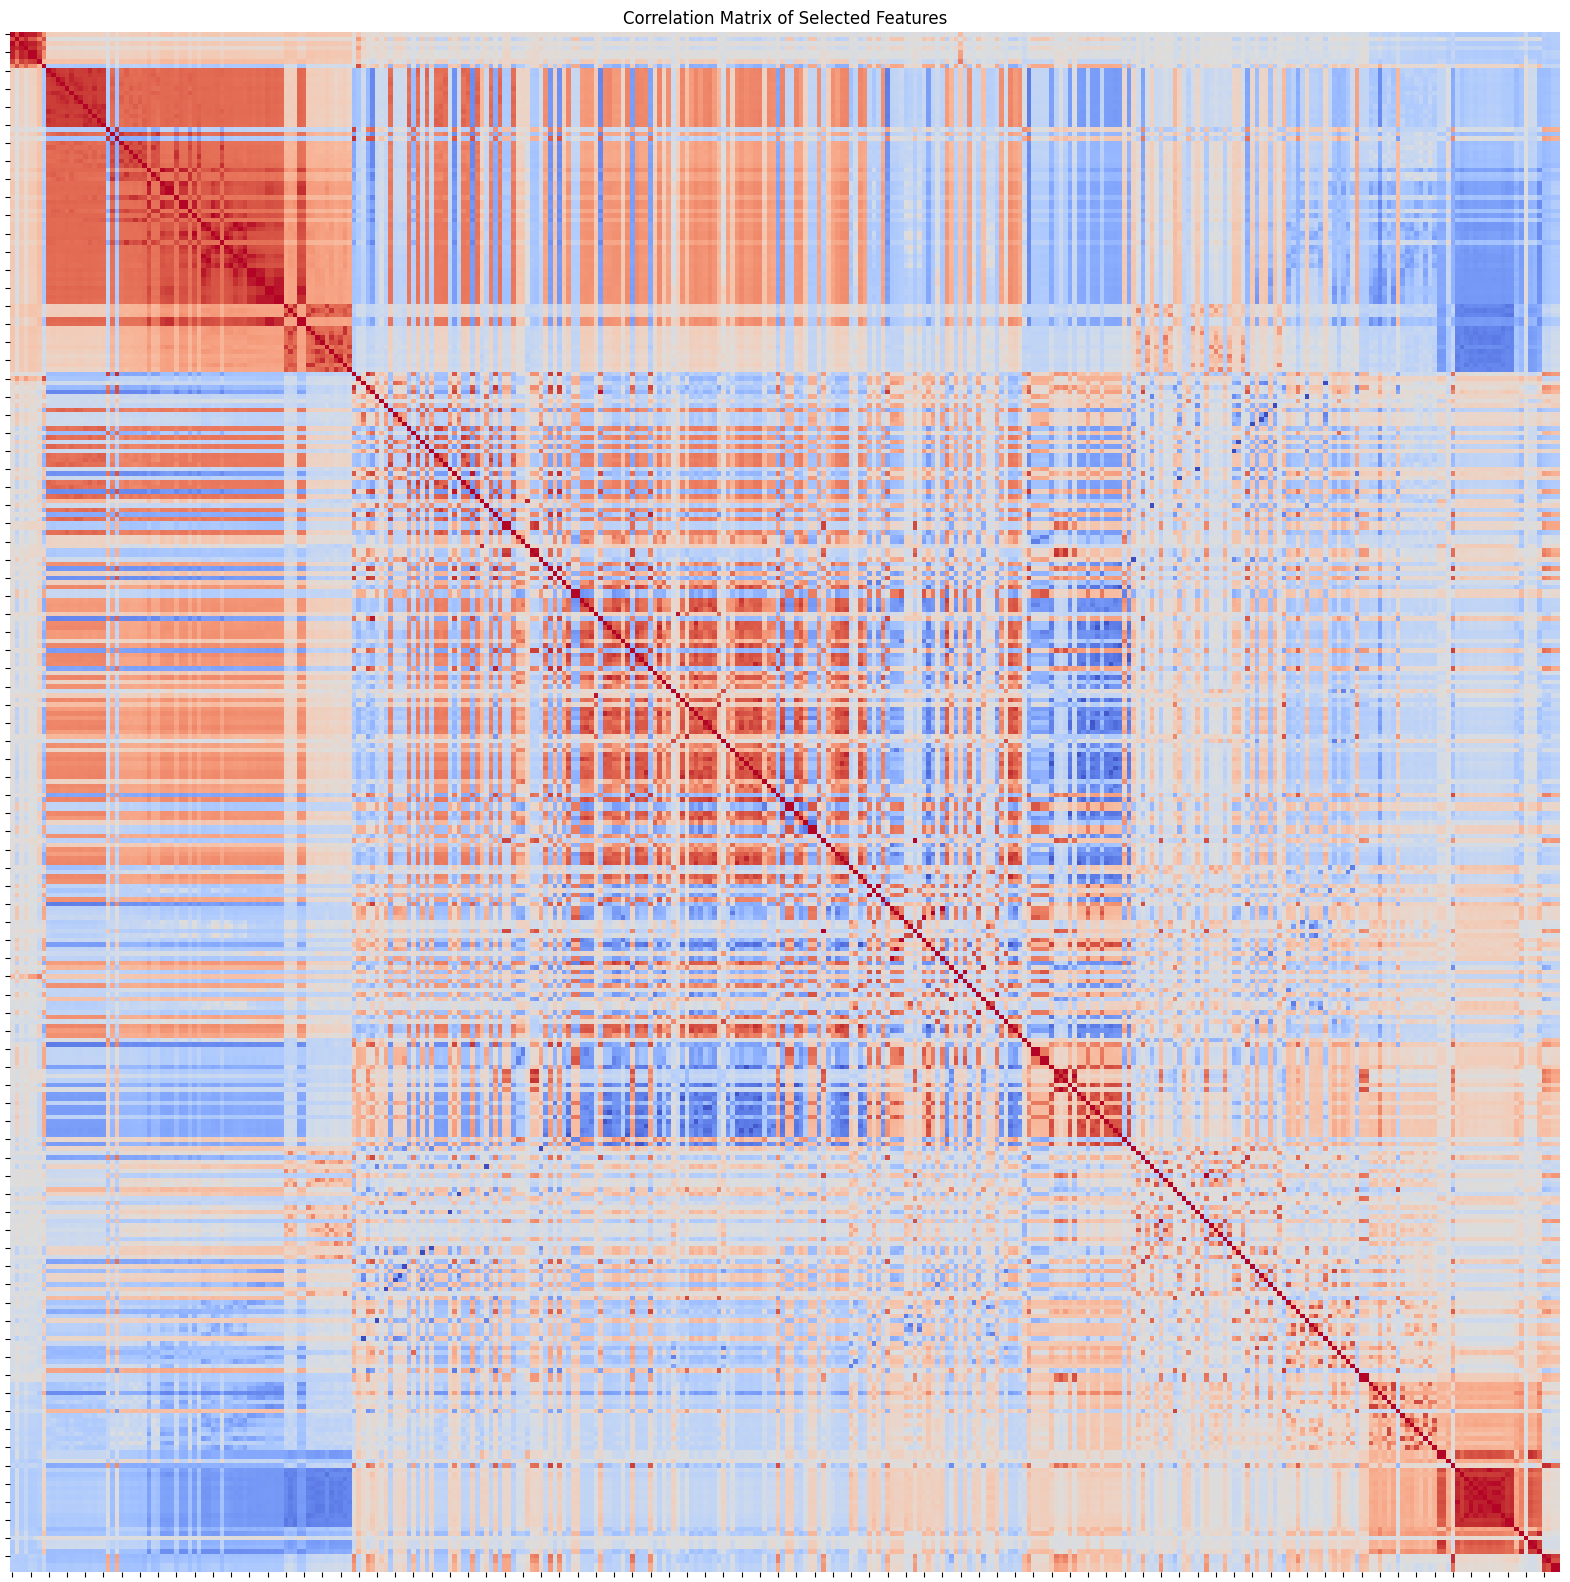

In [46]:
def compute_correlation_matrix(df, selected_features):
    return df[selected_features].corr()

correlation_matrix = compute_correlation_matrix(high_level_feature_df, all_features)

plt.figure(figsize=(20, 20))
ax = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [47]:
def remove_highly_correlated_features(df, selected_features, threshold=0.6):
    correlation_matrix = df[selected_features].corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    # Remove redundant features
    reduced_features = [feature for feature in selected_features if feature not in to_drop]

    return reduced_features


reduced_features = remove_highly_correlated_features(high_level_feature_df, all_features)
print(f"Reduced Features: {reduced_features}")


Reduced Features: ['spectral_contrast_var', 'mfcc_7_50th_percentile', 'spectral_bandwidth_25th_percentile', 'mfcc_12_range', 'chroma_1_range', 'chroma_5_range', 'zero_crossing_rate_min', 'chroma_10_range', 'chroma_8_range', 'spectral_flux_skew', 'zero_crossing_rate_max', 'chroma_8_kurtosis', 'chroma_7_75th_percentile', 'chroma_11_kurtosis', 'chroma_7_var', 'zero_crossing_rate_skew', 'chroma_2_kurtosis', 'mfcc_1_skew', 'mfcc_6_skew', 'mfcc_9_skew', 'mfcc_4_skew', 'spectral_bandwidth_min', 'mfcc_12_max', 'mfcc_11_mean', 'spectral_flux_min', 'spectral_contrast_min']


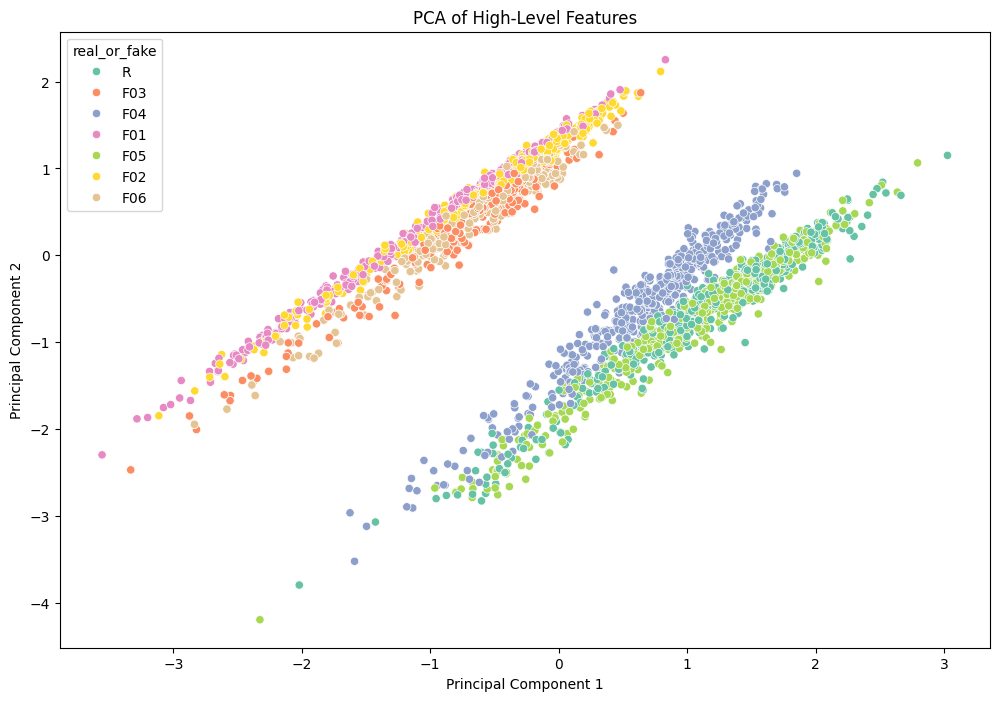

In [48]:
perform_pca_and_plot(high_level_feature_df, reduced_features)

In [49]:
importance_df = logistic_regression_feature_importance(high_level_feature_df, reduced_features[:2])
importance_df

,feature,importance
0,spectral_contrast_var,4.560466
1,mfcc_7_50th_percentile,0.367813


### Baseline Model

In [50]:
good_features = reduced_features[:20]

In [51]:
X = high_level_feature_df[good_features]
y = high_level_feature_df['real_or_fake'].apply(lambda x: 1 if x == 'R' else 0)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

model_performance = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Fake', 'Real'])
    
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Classification Report': report
    }


for model_name, metrics in model_performance.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print("Classification Report:\n", metrics['Classification Report'])
    print("-" * 60)


Model: Logistic Regression
Accuracy: 0.8529
Precision: 0.5636
Recall: 0.2818
F1 Score: 0.3758
Classification Report:
               precision    recall  f1-score   support

        Fake       0.88      0.96      0.92       590
        Real       0.56      0.28      0.38       110

    accuracy                           0.85       700
   macro avg       0.72      0.62      0.65       700
weighted avg       0.83      0.85      0.83       700

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8400
Precision: 0.4898
Recall: 0.4364
F1 Score: 0.4615
Classification Report:
               precision    recall  f1-score   support

        Fake       0.90      0.92      0.91       590
        Real       0.49      0.44      0.46       110

    accuracy                           0.84       700
   macro avg       0.69      0.68      0.68       700
weighted avg       0.83      0.84      0.84       700

-------------------------------------------------------